In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [77]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'device: {device}')

device: cuda:3


In [78]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,t):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,t], dim = 1)    #(N,2)

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)


            
        b = self.linears[-1](a) 
         
        return b
    

In [79]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [129]:
# Create the training data

import math

T=2*math.pi

x = torch.linspace(-1,1,200000).to(device).view(-1,1)
t = torch.linspace(0,1,200000).to(device).view(-1,1) * T


x_train = x.requires_grad_(True)      
t_train = t.requires_grad_(True)     

# x_train = x_train.reshape(-1,1).requires_grad_(True)     
# t_train = t_train.reshape(-1,1).requires_grad_(True)  

In [130]:
# Create boundary points

def generate_boundary_points(N = 20000):
    x_l = -torch.ones(N,1) ; x_r = torch.ones(N,1); t_lr = torch.linspace(0,1,N) * T

    x_l = x_l.view(-1,1)
    x_r = x_r.view(-1,1)
    t_lr = t_lr.view(-1,1)
   

  

    x_l = x_l.to(device)
    x_r = x_r.to(device)
    t_lr = t_lr.to(device)


    return x_l, x_r, t_lr

In [131]:
def boundary_condition():

    x_l, x_r, t_lr = generate_boundary_points(N = 20000)

    u_left = PINN(x_l, t_lr)
    u_right = PINN(x_r, t_lr)


    res_left = u_left - (-torch.cos(t_lr))
    res_right = u_right - torch.cos(t_lr)

    return res_left, res_right

In [132]:
def generate_initial_points(N = 2000):
    x_i = torch.linspace(-1, 1,N).view(-1,1)
    t_i = torch.zeros(N,1).view(-1,1).requires_grad_(True)

    x_i = x_i.to(device)
    t_i = t_i.to(device)
    
    return x_i, t_i

In [133]:

def initial_condition():

  x_i, t_i = generate_initial_points(N = 2000)
  
  u_ic = PINN(x_i, t_i)

  res_ic_1 = u_ic - x_i

  u_t = torch.autograd.grad(u_ic, t_i, torch.ones_like(u_ic), create_graph=True)[0]
  res_ic_2 = u_t - torch.zeros_like(u_t)

#   res_ic = res_ic_1 + res_ic_2

  return res_ic_1, res_ic_2

In [134]:
def pde_residual(x,t):
    u = PINN(x,t)

    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    du_dt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

    du_dx_x = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
    du_dt_t = torch.autograd.grad(du_dt, t, torch.ones_like(du_dt), create_graph=True)[0]

    res_pde = du_dt_t - du_dx_x + (u**2) + x*torch.cos(t)-(x**2) *torch.cos(t)**2

    return res_pde

In [135]:
def compute_losses():
   res_pde = pde_residual(x_train,t_train) 
   res_ic_1, res_ic_2 = initial_condition()
   res_left, res_right = boundary_condition()

   loss_pde = torch.mean(res_pde**2)
   loss_ic = torch.mean(res_ic_1**2) + torch.mean(res_ic_2**2)
   loss_bc = torch.mean(res_left**2) + torch.mean(res_right**2)

   total_loss = loss_pde + loss_ic + loss_bc

   return total_loss

In [ ]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [136]:
torch.manual_seed(42)
PINN = Sequentialmodel(layers).to(device)
# PINN = Sequentialmodel(layers)

In [30]:
# # Threshold loss as the stopping criteria

# max_epochs = 15000
# threshold = 0.002



# start_time = time.time()

# ep = 0
# while ep < max_epochs:
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()


#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at epoch {ep}")
#         break

#     if (ep) % 200 == 0:
#      print(f'Epoch {ep}, Loss: {total_loss.item()}')

#     ep += 1


# print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")


    








In [137]:
if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [138]:
# Using LBFGS

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

start_time = time.time()

loss_history = []
time_history = []

ep = 0


def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:

    total_loss = optimizer.step(closure)

    loss_val = float(total_loss.item())
    loss_history.append(loss_val)
    time_history.append(time.time() - start_time)

    # if total_loss.item() < threshold:
    #     print(f"Reached threshold loss {threshold} at outer step {ep}")
    #     break

    if loss_val < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break

    if ep % 200 == 0:
        # print(f'Outer {ep}, Loss: {total_loss.item()}')
        print(f'Outer {ep}, Loss: {loss_val}')

    ep += 1

elapsed = time.time() - start_time

# print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")

print(f"Training stopped at outer step {ep}, total time {elapsed:.2f} s")



np.save("kg_loss_autodiff.npy", np.array(loss_history))
np.save("kg_time_autodiff.npy", np.array(time_history))
    

Outer 0, Loss: 1.8135864734649658
Reached threshold loss 0.002 at outer step 15
Training stopped at outer step 15, total time 13.56 s


In [139]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    peak_MB = peak_mem / 1e6
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')
    np.save("kg_peak_mem_autodiff.npy", peak_MB)

Peak GPU Memory Usage:  2073.30 MB


In [92]:
def u_closed_form(x, t):
    sol = x*torch.cos(t)
    return sol

In [93]:
import math

T=2*math.pi

x_test = torch.linspace(-1,1,600).to(device).view(-1,1)
t_test = torch.rand(600,1) * T

t_test = t_test.to(device)

u_true = u_closed_form(x_test, t_test)
u_pred = PINN(x_test,t_test)

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")

MSE vs closed-form: 8.197e-03


In [94]:
def compare(PINN):
    PINN.eval()


    x_test = torch.linspace(-1,1,500).view(-1,1)
    t_test = torch.linspace(0,1,500).view(-1,1) * T

    x_test,t_test = torch.meshgrid(x_test.squeeze(),t_test.squeeze(), indexing = 'ij')

    x_test = x_test.reshape(-1,1).to(device)     
    t_test = t_test.reshape(-1,1).to(device) 



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
   

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


  


    u_true = u_closed_form(x_test, t_test).reshape(500,500)


    u_pred = PINN(x_test,t_test).reshape(500,500)

    u_pred_np = u_pred.detach().cpu()



    fig, axs = plt.subplots(1, 2, figsize=(12, 3.6), constrained_layout=True)
    im0 = axs[0].imshow(u_true.cpu(), origin='lower', cmap = "jet", extent=[0,T,-1,1])
    axs[0].set_title("Closed-form")
    axs[0].set_xlabel('t'); axs[0].set_ylabel('x'); fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np.cpu(), origin='lower', cmap = "jet", extent=[0,T,-1,1])
    axs[1].set_title("PINN Prediction")
    axs[1].set_xlabel('t'); axs[1].set_ylabel('x'); fig.colorbar(im1, ax=axs[1])



    # Saving the plot

    # plt.savefig('Closed-form_solution_vs_PINN_prediction.svg',format = 'svg',bbox_inches = 'tight')

    for ext in ["png", "pdf", "svg","eps"]:
      plt.savefig(f"Klein_Gordon_autograd.{ext}", bbox_inches='tight', dpi=300)

  

    plt.show()


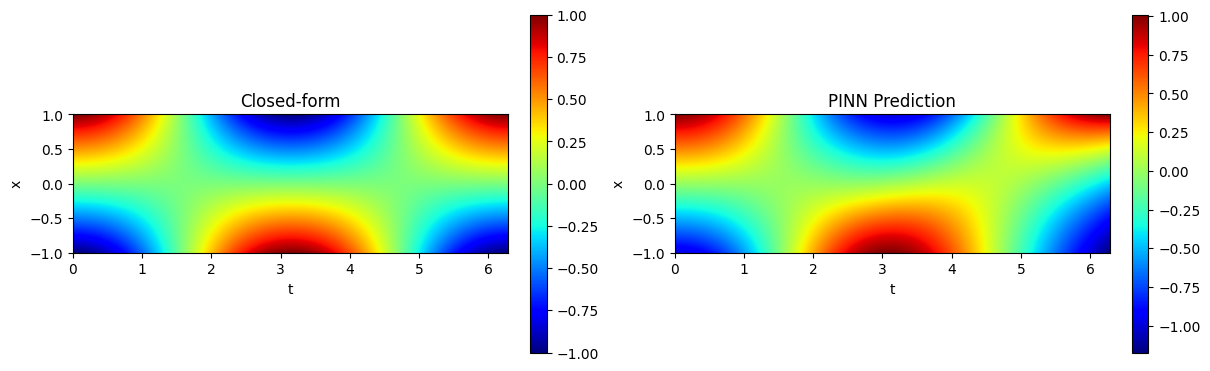

In [75]:
compare(PINN)